In [18]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 

In [19]:
#metrics
from sklearn.metrics import f1_score,confusion_matrix,precision_score,recall_score
from Weed_dataset import WeedDataset
from torch.utils.data import DataLoader
from arch import Architecture
from experimental_models.encoder_decoder.base_arch import MyArch
from data_script import read_file

In [95]:
#load model and samples

model=MyArch().to(device=torch.device('cpu'))

model.load_state_dict(torch.load("./models/deep_cnn/model280.pth"))

train,test=read_file()

dataset=WeedDataset(test,training=False)
loader=DataLoader(dataset,batch_size=30,shuffle=True)



l=list()
for i,(x_sample,y_sample) in enumerate(loader):
    x_sample=x_sample.to(device=torch.device("cpu"))
    y_sample=y_sample.to(device=torch.device("cpu"))

    predictions=model(x_sample)
    

In [96]:
#convert to HXWXC vectors

x_sample=x_sample.to(device=torch.device("cpu"))
x_sample=x_sample.permute(0,2,3,1)

y_sample=y_sample.to(device=torch.device("cpu"))
y_sample=y_sample.permute(0,2,3,1)


In [97]:
x_sample.shape

torch.Size([30, 1024, 1024, 3])

In [98]:
predictions.size()

torch.Size([30, 3, 1024, 1024])

In [99]:
import torch.nn.functional as f

predictions=predictions.to(device=torch.device("cpu"))

probs=f.softmax(predictions,dim=1)
preds=torch.argmax(probs,dim=1)
predictions=torch.zeros_like(probs).scatter_(1,preds.unsqueeze(1),1.)

predictions=predictions.permute(0,2,3,1)
    

Text(0.5, 1.0, 'Ground Truth')

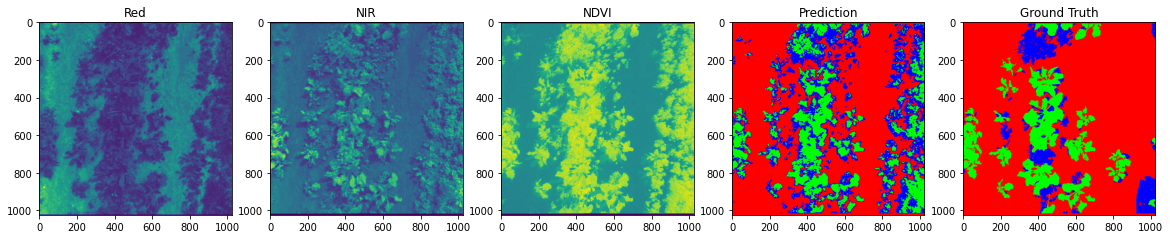

In [100]:
#Visualize

t=2
fig=plt.figure(figsize=(20,20),dpi=72)
ax1=fig.add_subplot(1,5,1)
ax1.imshow(x_sample[t,:,:,0])
ax1.set_title("Red")

ax2=fig.add_subplot(1,5,2)
ax2.imshow(x_sample[t,:,:,1])
ax2.set_title("NIR")

ax3=fig.add_subplot(1,5,3)
ax3.imshow(x_sample[t,:,:,2])
ax3.set_title("NDVI")


ax4=fig.add_subplot(1,5,4)
ax4.imshow(predictions[t])
ax4.set_title("Prediction")

ax5=fig.add_subplot(1,5,5)
ax5.imshow(y_sample[t])
ax5.set_title("Ground Truth")

In [101]:
#convert to numpy and flatten by (BXHXW,4)

y_np=y_sample.numpy()
pred_np=predictions.numpy()

In [102]:
y_np=np.reshape(y_np,(y_np.shape[0]*y_np.shape[1]*y_np.shape[2],3))
pred_np=np.reshape(pred_np,(pred_np.shape[0]*pred_np.shape[1]*pred_np.shape[2],3))


In [103]:
y_labels=np.where(y_np==1)[1]
pred_labels=np.where(pred_np==1)[1]

In [104]:
#metrics
f1=f1_score(y_labels,pred_labels,average='macro')
precision=precision_score(y_labels,pred_labels,average='macro')
recall=recall_score(y_labels,pred_labels,average='macro')

In [105]:
f1

0.639373179521216

In [106]:
precision

0.676142033977105

In [107]:
recall

0.6810956039074898

In [108]:
cf=confusion_matrix(y_labels,pred_labels,normalize='all')

In [109]:
cf

array([[0.50090653, 0.00568298, 0.12632847],
       [0.0013066 , 0.1368015 , 0.10461181],
       [0.00261345, 0.03615719, 0.08559148]])